In [2]:
from copy import deepcopy
import pickle as pkl
import time

import interfere
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

COLORS = [str(v) for v in mcolors.TABLEAU_COLORS.values()]
plt.rcParams["figure.dpi"] = 150

NOTEBOOK_RNG = np.random.default_rng(101)
SEED = 1
REPS = 10
SAVE_PARAMS = True
PLOT_DYNAMICS = True


# All Dynamic Models for Experiment 2: Finding the stochastic noise sweet spot

The following cells contain the parameters of the models that will be used to
study the existence of a stochastic sweet spot, where some stochastic noise
helps forecasting.

The following cell contains all packages and versions used to generate parameter
settings:

```
appnope==0.1.3
asttokens==2.4.1
cmake==3.28.1
comm==0.2.1
contourpy==1.2.0
cycler==0.12.1
debugpy==1.8.0
decorator==5.1.1
derivative==0.6.0
exceptiongroup==1.2.0
executing==2.0.1
filelock==3.13.1
fonttools==4.47.2
fsspec==2023.12.2
importlib-metadata==7.0.1
importlib-resources==6.1.1
iniconfig==2.0.0
-e git+https://github.com/djpasseyjr/interfere.git@5a31f8272698e081253f24d6b7a65a8a6a58984a#egg=interfere
ipykernel==6.29.0
ipython==8.18.1
jedi==0.19.1
Jinja2==3.1.3
joblib==1.3.2
jupyter_client==8.6.0
jupyter_core==5.7.1
kiwisolver==1.4.5
MarkupSafe==2.1.3
matplotlib==3.8.2
matplotlib-inline==0.1.6
mpmath==1.3.0
nest-asyncio==1.6.0
networkx==3.2.1
numpy==1.26.3
packaging==23.2
pandas==2.1.4
parso==0.8.3
patsy==0.5.6
pexpect==4.9.0
pillow==10.2.0
platformdirs==4.1.0
pluggy==1.3.0
prompt-toolkit==3.0.43
psutil==5.9.8
ptyprocess==0.7.0
pure-eval==0.2.2
pyclustering @ git+https://github.com/djpasseyjr/pyclustering@6bb2311e318d3b6ae7ef88f88ed19ec25e959b7f
Pygments==2.17.2
pyparsing==3.1.1
pysindy==1.7.5
pytest==7.4.4
python-dateutil==2.8.2
pytz==2023.3.post1
pyzmq==25.1.2
scikit-base==0.6.2
scikit-learn==1.3.2
scipy==1.11.4
scs==3.2.4.post1
sdeint==0.3.0
six==1.16.0
sktime==0.25.0
stack-data==0.6.3
statsmodels==0.14.1
sympy==1.12
threadpoolctl==3.2.0
tomli==2.0.1
torch==2.1.2
tornado==6.4
traitlets==5.14.1
typing_extensions==4.9.0
tzdata==2023.4
wcwidth==0.2.13
zipp==3.17.0
```

In [19]:
!pip freeze

appnope==0.1.3
asttokens==2.4.1
blinker==1.7.0
click==8.1.7
cmake==3.28.1
comm==0.2.1
contourpy==1.2.0
cycler==0.12.1
Cython==3.0.8
debugpy==1.8.0
decorator==5.1.1
derivative==0.6.0
dill==0.3.8
dnspython==2.6.1
entrypoints==0.4
enum34==1.1.10
exceptiongroup==1.2.0
executing==2.0.1
filelock==3.13.1
findiff==0.10.0
Flask==3.0.2
fonttools==4.47.2
fsspec==2023.12.2
GPy==1.13.1
importlib-metadata==7.0.1
importlib-resources==6.1.1
iniconfig==2.0.0
-e git+https://github.com/djpasseyjr/interfere.git@9d3a67ba631dc4fdfe28e33c736785e80238cff3#egg=interfere
ipykernel==6.29.0
ipyparallel==8.7.0
ipython==8.18.1
itsdangerous==2.1.2
jedi==0.19.1
Jinja2==3.1.3
joblib==1.3.2
jupyter_client==8.6.0
jupyter_core==5.7.1
kiwisolver==1.4.5
MarkupSafe==2.1.3
matplotlib==3.8.2
matplotlib-inline==0.1.6
mpmath==1.3.0
nest-asyncio==1.6.0
networkx==3.2.1
numdifftools==0.9.41
numpy==1.26.3
packaging==23.2
pandas==2.1.4
paramz==0.9.6
parso==0.8.3
patsy==0.5.6
pexpect==4.9.0
pillow==10.2.0
platformdirs==4.1.0
pluggy==

In [20]:
all_params = [] 

In [21]:
def update_stochastic_size(params: dict, stochastic_magnitude: float):
    """Creates stochastic param set with a given magnitude of stochasticity.
    """
    stoch_params = deepcopy(params)
    stoch_params["stochastic_magnitude"] = stochastic_magnitude

    if "sigma" in stoch_params["model_params"]:
        sig = stoch_params["model_params"]["sigma"]

        # Float parameters.
        if isinstance(sig, (float, int)):
            stoch_params["model_params"]["sigma"]= stochastic_magnitude

        # Array parameters.
        if isinstance(sig, np.ndarray):
            if len(sig.shape) == 1:
                new_sig = stochastic_magnitude * np.ones_like(sig)
                stoch_params["model_params"]["sigma"] = new_sig

            elif len(sig.shape) == 2:
                new_sig = stochastic_magnitude * np.diag(np.ones_like(sig))
                stoch_params["model_params"]["sigma"] = new_sig

            else:
                raise ValueError("Stochastic array has incompatible shape.")
            
    else:
        raise ValueError("No stochastic parameter found in parameter set.")
        


    

In [22]:
def add_stochastic_noise_param_sets(
        determ_params, all_params, max_stoch_noise_ratio=2, num_stoch_sims=9, min_stoch=1e-8):
    """Plots the model and the change in response to intervention.

    Args:
        determ_params (dict): Deterministic system parameters.
        all_params (list): Current list of parameter sets.
        max_stochastic_noise_ratio (float): Maximum amount of stochastic noise
            to experiment with. Computed relative to the largest discrete 
            change in the deterministic system.
        num_stoch_sims (int): Number of stochastic parameter sets to create.
        min_stoch (float): The size of the smallest stochastic perturbation.
    """

    one_ic = determ_params["initial_conds"][:1]
    Xs, X_dos, t = interfere.generate_counterfactual_forecasts(
        **{**determ_params, "initial_conds": one_ic})
    X = Xs[0]
    X_do = X_dos[0]

    # Compute the max change across time steps in the deterministic system.
    delta_max = np.max(np.abs(np.diff(X, axis=0)))
    stochastic_sizes = np.logspace(
        np.log10(min_stoch),
        np.log10(max_stoch_noise_ratio * delta_max),
        num_stoch_sims
    )

    # Prepend stochastic sizes with zero.
    stochastic_sizes = [0.0] + list(stochastic_sizes)


    # Add a param to denote that the deterministic model has zero stochasticity.
    determ_params["stochastic_size"] = 0.0
    # Store max step size used.
    determ_params["delta_max"] = delta_max

    # Create stochastic parameter sets.
    stoch_param_sets = [
        update_stochastic_size(determ_params, s)
        for s in stochastic_sizes
    ]

    # Add stochastic sets to all params.
    all_params += stoch_param_sets

        
    if PLOT_DYNAMICS:

        train_idx, dims = X_do.shape
        fig, ax = plt.subplots(dims, 1, figsize=(7, 10))
        for i in range(dims):
            ax[i].plot(t, X[:, i], alpha=0.7, c=COLORS[0])
            ax[i].plot(t[-train_idx:], X_do[:, i], alpha=0.7, c=COLORS[3])


        ax[-1].plot([0, 0], [0, 0], alpha=0.7, c=COLORS[0], label="Observed Signals")
        ax[-1].plot([0, 0], [0, 0], alpha=0.7, c=COLORS[3], label="Response to Intervention")

        plt.legend(loc=(0.2, -.5))
        plt.suptitle(determ_params["model_type"].__name__ )
        plt.tight_layout()
        plt.show()

### Uniform initial condition generator

In [23]:
def uniform_init_cond(min_x, max_x, dim, reps, rng=NOTEBOOK_RNG):
    """Generates initial conditions for dynamic models."""
    return [
        (max_x - min_x) * rng.random(dim) + min_x for i in range(reps)
    ]

### Arithmetic Brownian Motion

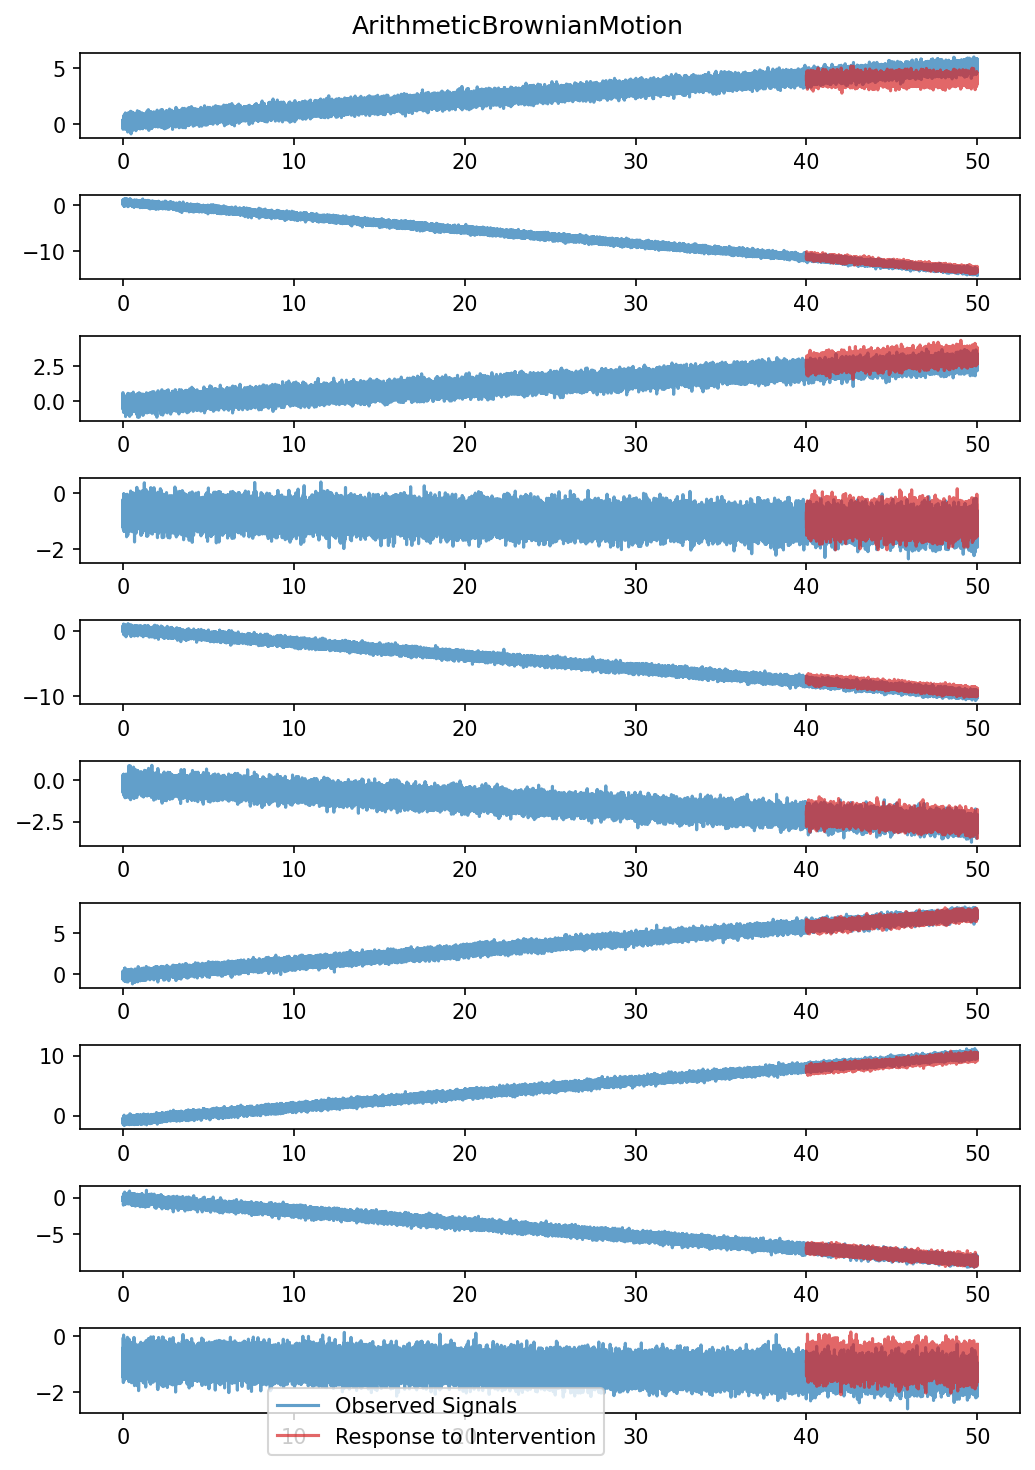

In [25]:
dim = 10

params = dict(
    model_type=interfere.dynamics.ArithmeticBrownianMotion,
    model_params={
        "mu": np.array([0.1, -0.3, 0.06, -0.01, -0.2,
                        -0.05, 0.15, 0.22, -0.17, -0.01]), 
        "sigma": np.zeros(dim),
        "measurement_noise_std": 0.3 * np.ones(dim)
    },
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 4.0},
    initial_conds=uniform_init_cond(-1, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

### Attracting Fixed Point 4D

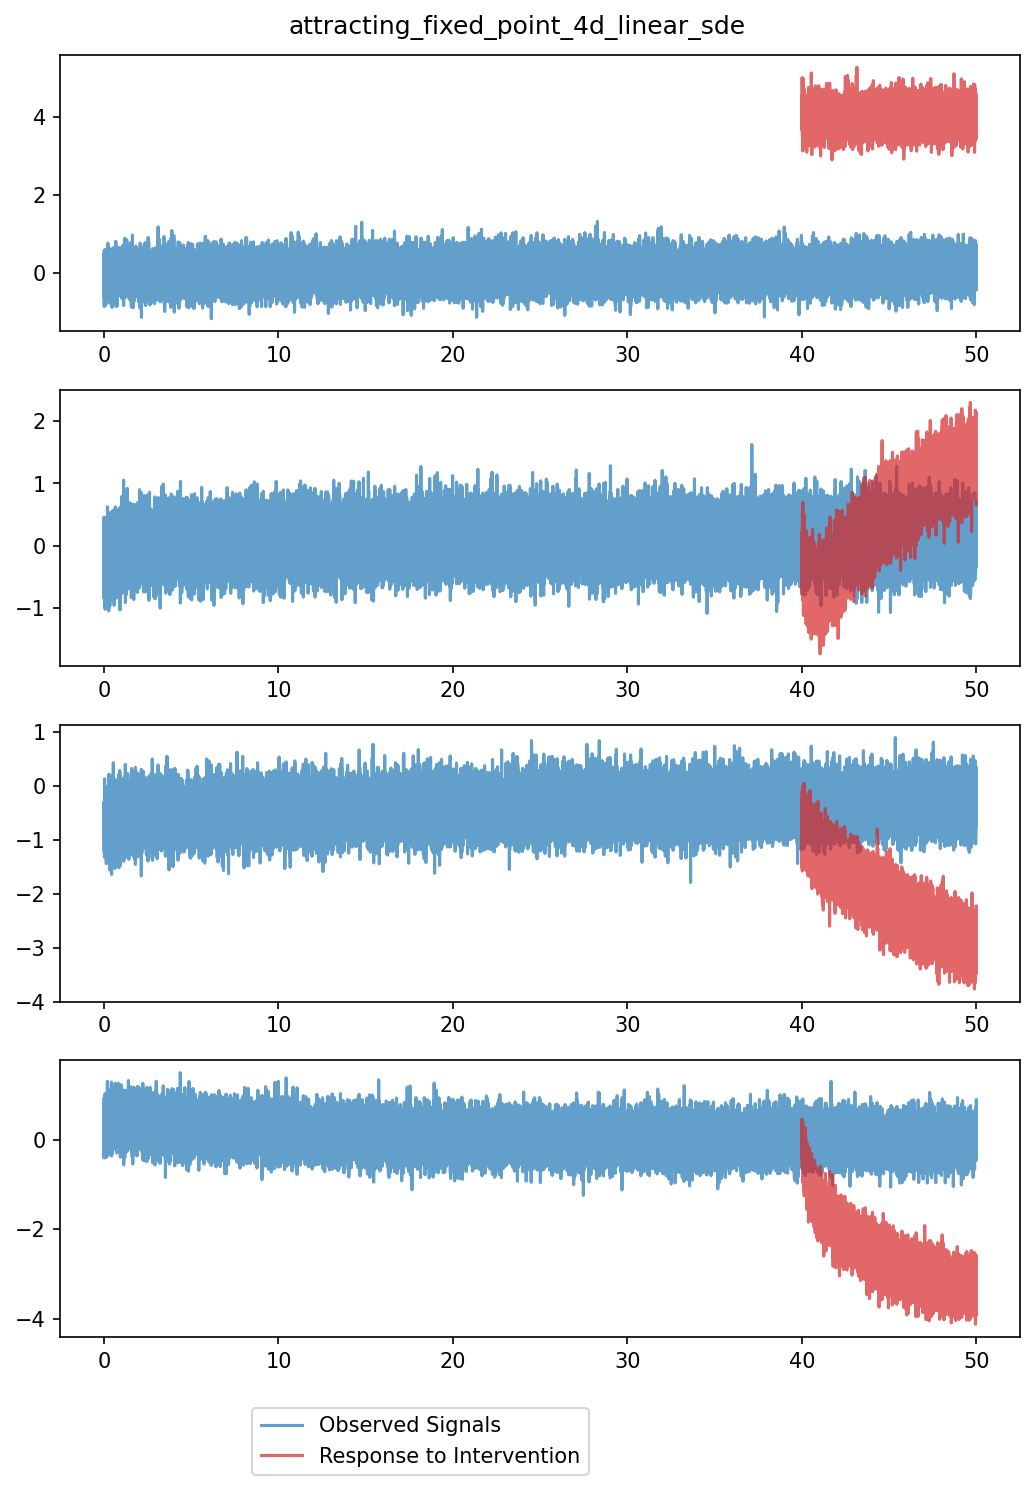

In [26]:
dim = 4

params = dict(
    model_type=interfere.dynamics.attracting_fixed_point_4d_linear_sde,
    model_params={"sigma": 0.0, "measurement_noise_std": 0.3 * np.ones(4)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 4.0},
    initial_conds=uniform_init_cond(-1, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

### Belozyorov 3D Quadratic SDE

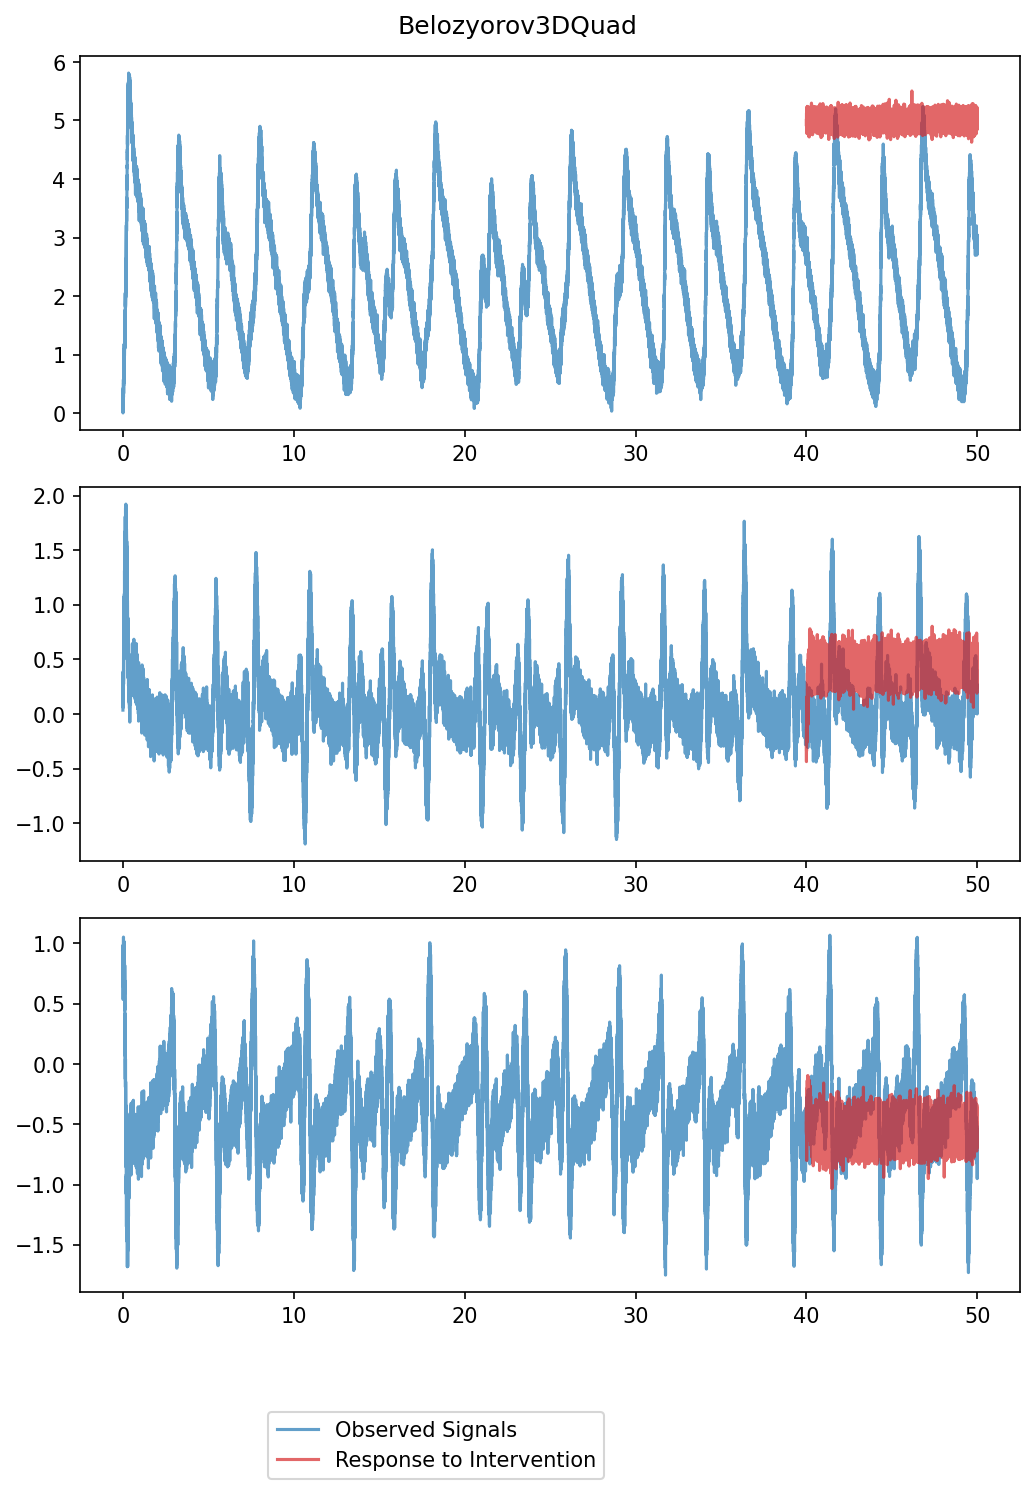

In [27]:
dim = 3

params = dict(
    model_type=interfere.dynamics.Belozyorov3DQuad,
    model_params={
        "mu": 1.81,
        "sigma": 0.0,
        "measurement_noise_std": 0.1 * np.ones(3)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 5.0},
    initial_conds=uniform_init_cond(-1, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

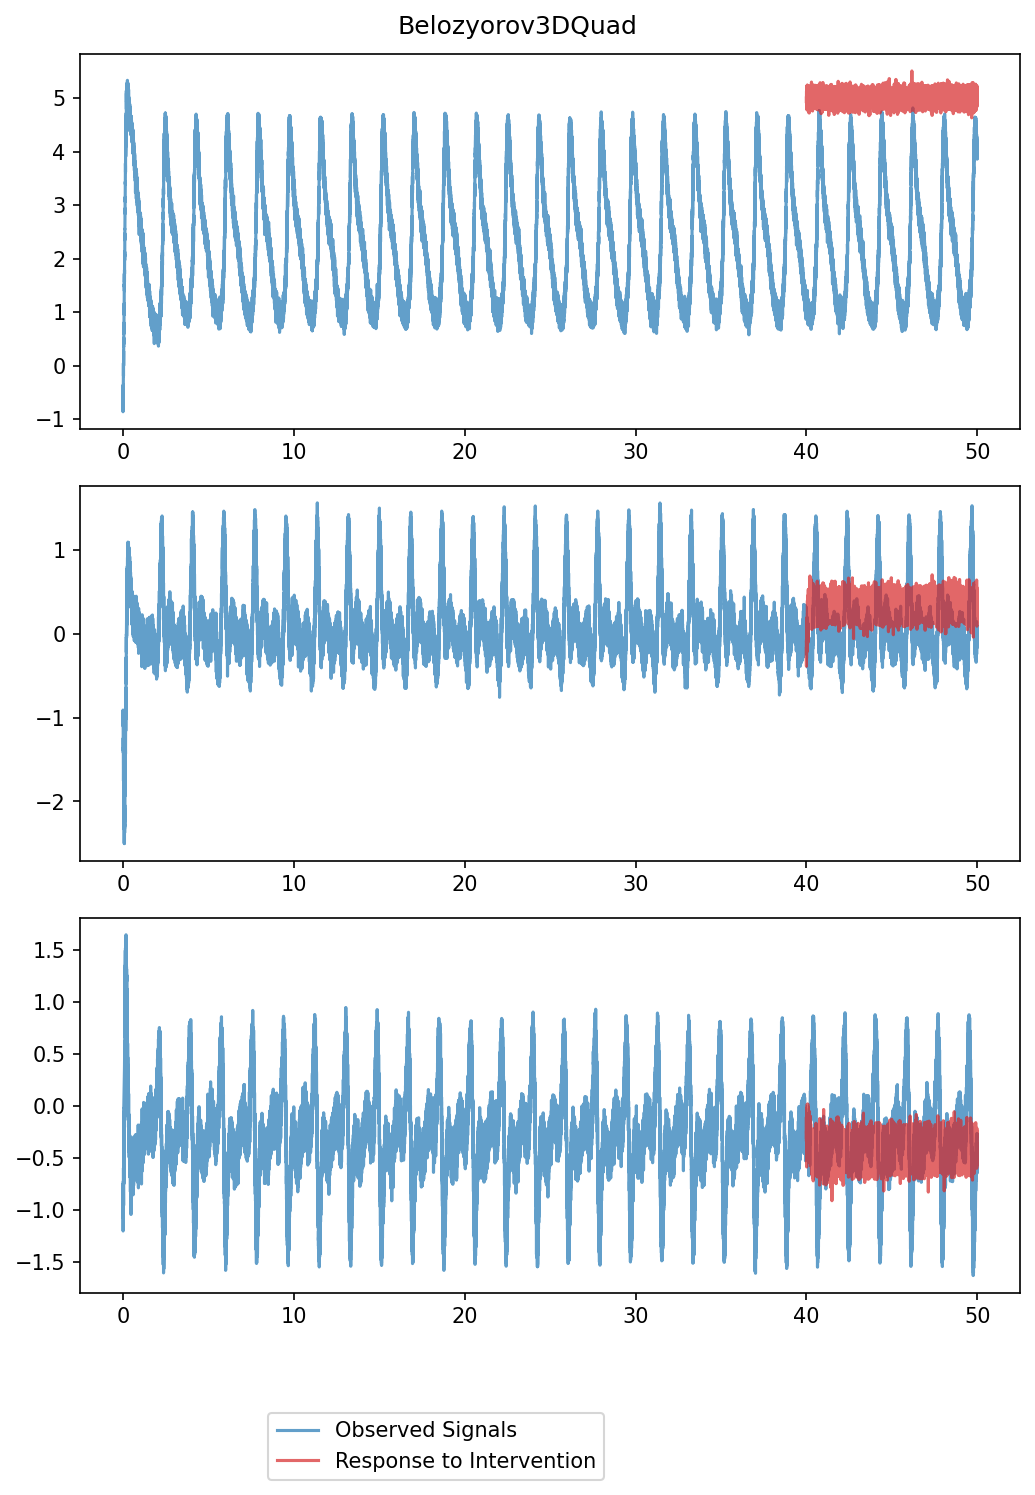

In [28]:
dim = 3

params = dict(
    model_type=interfere.dynamics.Belozyorov3DQuad,
    model_params={
        "mu": 1.4,
        "sigma": 0.0,
        "measurement_noise_std": 0.1 * np.ones(3)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 5.0},
    initial_conds=uniform_init_cond(-1, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [10]:
dim = 3

params = dict(
    model_type=interfere.dynamics.Belozyorov3DQuad,
    model_params={
        "mu": 2.2,
        "sigma": 0.0,
        "measurement_noise_std": 0.1 * np.ones(3)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 5.0},
    initial_conds=uniform_init_cond(-1, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)



add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

### Coupled logistic maps

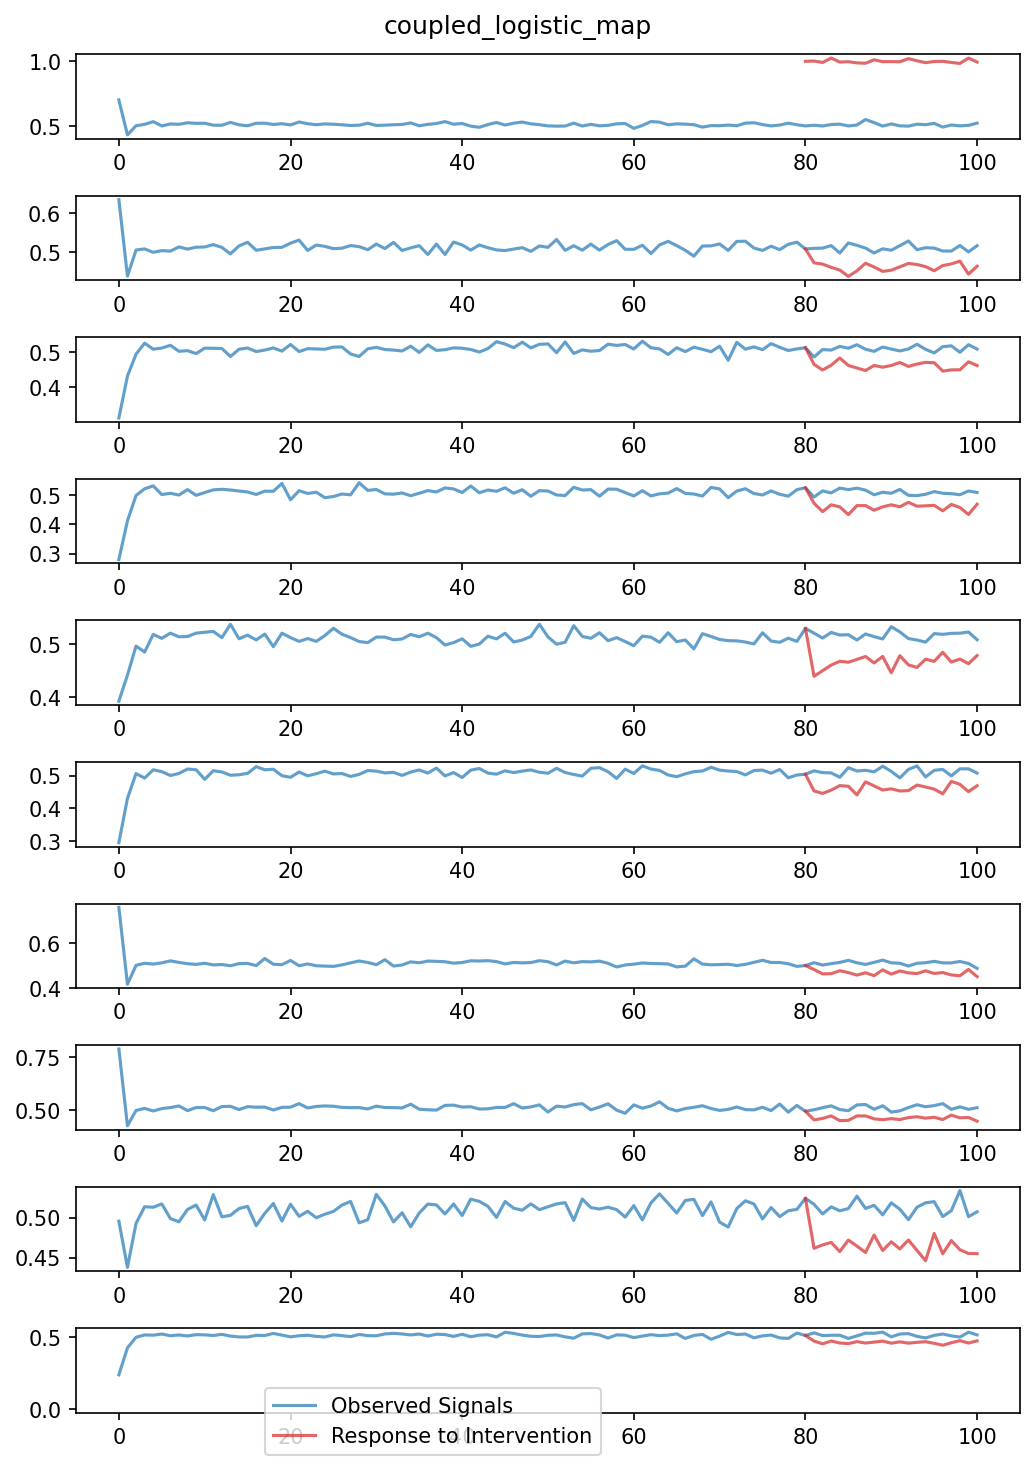

In [29]:
dim = 10

params = dict(
    model_type=interfere.dynamics.coupled_logistic_map,
    model_params={
        "adjacency_matrix": np.ones((dim, dim)),
        "eps": 0.5,
        "logistic_param": 3.72,
        "sigma": 0.0,
        "measurement_noise_std": 0.01 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 1.0},
    initial_conds=uniform_init_cond(0, 1, dim, REPS),
    start_time=0, end_time=100, dt=1,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [12]:
dim = 10

params = dict(
    model_type=interfere.dynamics.coupled_logistic_map,
    model_params={
        # Two cycles and isolated node
        "adjacency_matrix": np.array([
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        ]),
        "eps": 0.9,
        "logistic_param": 3.72,
        "sigma": 0.0,
        "measurement_noise_std": 0.01 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 1.0},
    initial_conds=uniform_init_cond(0, 1, dim, REPS),
    start_time=0, end_time=100, dt=1,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [13]:
dim = 10

params = dict(
    model_type=interfere.dynamics.coupled_logistic_map,
    model_params={
        # Two cycles and isolated node
        "adjacency_matrix": np.array([
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        ]),
        "eps": 0.3,
        "logistic_param": 3.0,
        "sigma": 0.0,
        "measurement_noise_std": 0.01 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 1.0},
    initial_conds=uniform_init_cond(0, 1, dim, REPS),
    start_time=0, end_time=100, dt=1,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

### Coupled Lattice Map (quadratic map)

In [14]:
dim = 10

params = dict(
    model_type=interfere.dynamics.coupled_map_1dlattice_chaotic_brownian,
    model_params={
        "dim": dim,
        "sigma": 0.0,
        "measurement_noise_std": 0.05 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -0.5},
    initial_conds=uniform_init_cond(0, 1, dim, REPS),
    start_time=0, end_time=100, dt=1,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [15]:
dim = 10

params = dict(
    model_type=interfere.dynamics.coupled_map_1dlattice_chaotic_traveling_wave,
    model_params={
        "dim": dim,
        "sigma": 0.0,
        "measurement_noise_std": 0.05 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 0.5},
    initial_conds=uniform_init_cond(0, 1, dim, REPS),
    start_time=0, end_time=100, dt=1,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [16]:
dim = 10

params = dict(
    model_type=interfere.dynamics.coupled_map_1dlattice_defect_turbulence,
    model_params={
        "dim": dim,
        "sigma": 0.0,
        "measurement_noise_std": 0.01 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -0.5},
    initial_conds=uniform_init_cond(0, 1, dim, REPS),
    start_time=0, end_time=100, dt=1,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [17]:
dim = 10

params = dict(
    model_type=interfere.dynamics.coupled_map_1dlattice_frozen_chaos,
    model_params={
        "dim": dim,
        "sigma": 0.0,
        "measurement_noise_std": 0.02 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -0.5},
    initial_conds=uniform_init_cond(0, 1, dim, REPS),
    start_time=0, end_time=100, dt=1,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [18]:
dim = 10

params = dict(
    model_type=interfere.dynamics.coupled_map_1dlattice_pattern_selection,
    model_params={
        "dim": dim,
        "sigma": 0.0,
        "measurement_noise_std": 0.02 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -0.5},
    initial_conds=uniform_init_cond(0, 1, dim, REPS),
    start_time=0, end_time=100, dt=1,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [19]:
dim = 10

params = dict(
    model_type=interfere.dynamics.coupled_map_1dlattice_spatiotemp_chaos,
    model_params={
        "dim": dim,
        "sigma": 0.0,
        "measurement_noise_std": 0.05 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -0.5},
    initial_conds=uniform_init_cond(0, 1, dim, REPS),
    start_time=0, end_time=100, dt=1,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [20]:
dim = 10

params = dict(
    model_type=interfere.dynamics.coupled_map_1dlattice_spatiotemp_intermit1,
    model_params={
        "dim": dim,
        "sigma": 0.0,
        "measurement_noise_std": 0.05 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 0.5},
    initial_conds=uniform_init_cond(0, 1, dim, REPS),
    start_time=0, end_time=100, dt=1,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [21]:
dim = 10

params = dict(
    model_type=interfere.dynamics.coupled_map_1dlattice_traveling_wave,
    model_params={
        "dim": dim,
        "sigma": 0.0,
        "measurement_noise_std": 0.05 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 0.5},
    initial_conds=uniform_init_cond(0, 1, dim, REPS),
    start_time=0, end_time=100, dt=1,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

### Damped Oscilator

In [22]:
dim = 2

params = dict(
    model_type=interfere.dynamics.DampedOscillator,
    model_params={"m": 1.0, "c": 2, "k": 10, "sigma": 0,
                  "measurement_noise_std": 0.1 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -0.5},
    initial_conds=uniform_init_cond(-1, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [23]:
dim = 2

params = dict(
    model_type=interfere.dynamics.DampedOscillator,
    model_params={"m": 30.0, "c": 0.5, "k": 2, "sigma": 0,
                  "measurement_noise_std": 0.1 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -0.5},
    initial_conds=uniform_init_cond(-1, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

### Geometric Browian Motion

In [24]:
dim = 10

params = dict(
    model_type=interfere.dynamics.GeometricBrownianMotion,
    model_params={
        "mu": np.array([
            -0.2, 0.003, -10, -0.0007, -1.3, -6, -0.8, -7, -0.38, -99.0]),
        "sigma": np.zeros(dim),
        "measurement_noise_std": 0.01 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 0.5},
    initial_conds=uniform_init_cond(-1, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [25]:
dim = 10

params = dict(
    model_type=interfere.dynamics.GeometricBrownianMotion,
    model_params={
        "mu": np.array([
            -0.2, 0.003, -10, -0.0007, -1.3, -6, -0.8, -7, -0.38, -99.0]),
        "sigma": np.zeros(dim),
        "measurement_noise_std": 0.01 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 0.5},
    initial_conds=uniform_init_cond(-1, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

### Hodgkin Huxley 

In [26]:
dim = 10

params = dict(
    model_type=interfere.dynamics.HodgkinHuxleyPyclustering,
    model_params={
        "stimulus": NOTEBOOK_RNG.random(dim) * 50 - 20,
        "sigma": np.zeros(dim),
        "w1": 0,
        "w2": 1.0,
        "w3": 0,
        "measurement_noise_std": 5 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -20},
    initial_conds=uniform_init_cond(-40, 10, dim, REPS),
    start_time=0, end_time=50, dt=0.0001,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

### Imaginary Roots 4D

In [27]:
dim = 4

params = dict(
    model_type=interfere.dynamics.imag_roots_4d_linear_sde,
    model_params={"sigma": 0,
                  "measurement_noise_std": np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -0.5},
    initial_conds=uniform_init_cond(0, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

### Kuramoto Oscilators

In [28]:
dim = 10

params = dict(
    model_type=interfere.dynamics.Kuramoto,
    model_params={
        "omega": NOTEBOOK_RNG.random(10) * np.pi / 2,
        "K": 2.5,
        # A chain network
        "adjacency_matrix": np.array([
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        ]),
        "sigma": 0,
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -0.5},
    initial_conds=uniform_init_cond(-1, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [29]:
dim = 10

params = dict(
    model_type=interfere.dynamics.Kuramoto,
    model_params={
        "omega": NOTEBOOK_RNG.random(10) * np.pi / 2,
        "K": 2.5,
        # A cycle and isolated node
        "adjacency_matrix": np.array([
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        ]),
        "sigma": 0,
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -0.5},
    initial_conds=uniform_init_cond(-1, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [30]:
dim = 10

params = dict(
    model_type=interfere.dynamics.Kuramoto,
    model_params={
        # All nodes have the same fundamental frequency
        "omega": np.ones(dim),
        "K": 2.5,
        # A cycle and isolated node
        "adjacency_matrix": np.array([
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        ]),
        "sigma": 0,
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -0.5},
    # Nodes begin synchronized but the intervention reveals coupling.
    initial_conds=uniform_init_cond(-1, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

### Kuramoto-Sakaguchi

In [31]:
dim = 10

params = dict(
    model_type=interfere.dynamics.KuramotoSakaguchi,
    model_params={
        "omega": NOTEBOOK_RNG.random(dim) * np.pi / 2,
        "K": 2.5,
        # A chain network
        "adjacency_matrix": np.array([
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        ]),
        "phase_frustration": np.array([
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        ]),
        "sigma": 0,
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -0.5},
    initial_conds=uniform_init_cond(-1, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [32]:
dim = 10

params = dict(
    model_type=interfere.dynamics.KuramotoSakaguchi,
    model_params={
        "omega": NOTEBOOK_RNG.random(dim) * np.pi / 2,
        "K": 2.5,
        # Three cycle and isolated node
        # A cycle and isolated node
        "adjacency_matrix": np.array([
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        ]),
        "phase_frustration": np.array([
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        ]),
        "sigma": 0,
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -0.5},
    initial_conds=uniform_init_cond(-1, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [33]:
dim = 10

params = dict(
    model_type=interfere.dynamics.KuramotoSakaguchi,
    model_params={
        # All nodes have the same fundamental frequency
        "omega": np.ones(dim),
        "K": 2.5,
        # A cycle and isolated node
        "adjacency_matrix": np.array([
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        ]),
        "phase_frustration": np.array([
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        ]),
        "sigma": 0,
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -0.5},
    # Nodes begin synchronized but the intervention reveals coupling.
    initial_conds=uniform_init_cond(1, 1, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

### Liping Finance Model

In [34]:
dim = 3

params = dict(
    model_type=interfere.dynamics.Liping3DQuadFinance,
    model_params={
        "sigma": 0,
        "measurement_noise_std": 0.25 * np.ones(dim),
    },
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": -0.1},
    initial_conds=uniform_init_cond(-2, 2, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

### Lotka Voltera

In [35]:
dim = 10

params = dict(
    model_type=interfere.dynamics.LotkaVolteraSDE,
    model_params={
        "growth_rates": 5 * NOTEBOOK_RNG.random(dim),
        "capacities": 20 * np.ones(dim),
        # A cycle and isolated node
        "interaction_mat": np.array([
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        ]),
        "sigma": 0,
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 5.0},
    initial_conds=uniform_init_cond(0, 10, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [36]:
dim = 10

params = dict(
    model_type=interfere.dynamics.LotkaVolteraSDE,
    model_params={
        # All nodes have the same growth rate
        "growth_rates": np.ones(dim),
        "capacities": 20 * np.ones(dim),
        # Three cycle and isolated node
        "interaction_mat": np.array([
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        ]),
        "sigma": 0,
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 5.0},
    # Nodes begin synchronized but the intervention reveals coupling.
    initial_conds=uniform_init_cond(2, 2, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [37]:
dim = 10

params = dict(
    model_type=interfere.dynamics.LotkaVolteraSDE,
    model_params={
        # All nodes have the same growth rate
        "growth_rates": np.ones(dim),
        "capacities": 20 * np.ones(dim),
        # Erdos-Renyi with mean degree 3
        "interaction_mat": NOTEBOOK_RNG.random((dim, dim)) < 3 / dim,
        "sigma": 0,
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 10.0},
    # Nodes begin synchronized but the intervention reveals coupling.
    initial_conds=uniform_init_cond(0, 6, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [38]:
dim = 10

params = dict(
    model_type=interfere.dynamics.LotkaVolteraSDE,
    model_params={
        "growth_rates": 2 * NOTEBOOK_RNG.random(dim),
        "capacities": 20 * np.ones(dim),
        # Erdos-Renyi with mean degree 3
        "interaction_mat": NOTEBOOK_RNG.random((dim, dim)) < 3 / dim,
        "sigma": 0,
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 10.0},
    initial_conds=uniform_init_cond(0, 6, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

### Ornstein Uhlenbeck

In [39]:
dim = 10

# Random orthonormal matrix
U = np.linalg.svd(NOTEBOOK_RNG.random((dim, dim)))[0]
# Random maxtix with all positive eigs
theta = U @ np.diag(10 * NOTEBOOK_RNG.random(dim)) @ U.T

params = dict(
    model_type=interfere.dynamics.OrnsteinUhlenbeck,
    model_params={
        "mu": 0.25 * np.ones(dim),
        # Chain
        "theta": theta,
        "sigma": np.zeros((dim, dim)),
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 2.0},
    initial_conds=uniform_init_cond(-3, 3, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [40]:
dim = 10

# Random orthonormal matrix
U = np.linalg.svd(NOTEBOOK_RNG.random((dim, dim)))[0]
# Random maxtix with all positive eigs
theta = U @ np.diag(0.5 * NOTEBOOK_RNG.random(dim)) @ U.T

params = dict(
    model_type=interfere.dynamics.OrnsteinUhlenbeck,
    model_params={
        "mu": 0.25 * np.ones(dim),
        # Chain
        "theta": theta,
        "sigma": np.zeros((dim, dim)),
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 2.0},
    initial_conds=uniform_init_cond(-3, 3, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [41]:
dim = 10

# Random orthonormal matrix
U = np.linalg.svd(NOTEBOOK_RNG.random((dim, dim)))[0]
# Random maxtix with all positive eigs
theta = U @ np.diag(10 * NOTEBOOK_RNG.random(dim)) @ U.T

params = dict(
    model_type=interfere.dynamics.OrnsteinUhlenbeck,
    model_params={
        "mu": 0.25 * np.ones(dim),
        # Chain
        "theta": theta,
        "sigma": np.zeros((dim, dim)),
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 2.0},
    initial_conds=uniform_init_cond(-3, 3, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [42]:
dim = 10

# Random orthonormal matrix
U = np.linalg.svd(NOTEBOOK_RNG.random((dim, dim)))[0]
# Random maxtix with all positive eigs
theta = U @ np.diag(10 * NOTEBOOK_RNG.random(dim)) @ U.T

params = dict(
    model_type=interfere.dynamics.OrnsteinUhlenbeck,
    model_params={
        "mu": 0.25 * np.ones(dim),
        # Chain
        "theta": theta,
        "sigma": np.zeros((dim, dim)),
        "measurement_noise_std": 0.25 * np.ones(dim)},
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 2.0},
    initial_conds=uniform_init_cond(-3, 3, dim, REPS),
    start_time=0, end_time=50, dt=0.001,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

### VARMA Models

In [6]:
from statsmodels.tsa.statespace.varmax import VARMAX

def extract_covariance(statsmodels_var_result):
    cov_table = np.array(statsmodels_var_result.summary().tables[-1])
    # Extract entries
    X = np.vectorize(lambda x: x.data)(cov_table)

    # Initialize empty cov matrix
    cov = [["0"]* 10 for i in range(10)]
    for i in range(0, 10):
        for j in range(i+1):
            cov[i][j] = X[j + i + 1, 1]

    cov = np.array(cov, float)
    cov = cov + np.tril(cov).T
    return cov

In [44]:
dim = 10

model = interfere.dynamics.coupled_map_1dlattice_spatiotemp_chaos(**{
    "dim": dim,
    "sigma": 0.0,
    "measurement_noise_std": 0.05 * np.ones(dim)
})

X = model.simulate(np.ones(dim), np.arange(100))
varma = VARMAX(X, order=(2, 3)).fit()

params = dict(
    model_type=interfere.dynamics.VARMA_Dynamics,
    model_params={
        "phi_matrices": varma.coefficient_matrices_var,
        "theta_matrices": varma.coefficient_matrices_vma,
        "sigma": extract_covariance(varma),
        "measurement_noise_std": 0.2 * np.ones(dim),
    },
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 1.5},
    # Nodes begin synchronized.
    initial_conds=uniform_init_cond(-3, 3, dim, REPS),
    start_time=0, end_time=100, dt=1,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          565     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.21904D+01    |proj g|=  1.41201D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  565      1     21      1     0     0   1.412D+01  -1.219D+01
  F =  -12.190429186205650     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [45]:
dim = 10

model = interfere.dynamics.coupled_map_1dlattice_chaotic_brownian(**{
    "dim": dim,
    "sigma": 0.0,
    "measurement_noise_std": 0.05 * np.ones(dim)
})

X = model.simulate(np.ones(dim), np.arange(100))
varma = VARMAX(X, order=(2, 3)).fit()

params = dict(
    model_type=interfere.dynamics.VARMA_Dynamics,
    model_params={
        "phi_matrices": varma.coefficient_matrices_var,
        "theta_matrices": varma.coefficient_matrices_vma,
        "sigma": extract_covariance(varma),
        "measurement_noise_std": 0.2 * np.ones(dim),
    },
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 1.5},
    # Nodes begin synchronized.
    initial_conds=uniform_init_cond(-3, 3, dim, REPS),
    start_time=0, end_time=100, dt=1,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          565     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.68569D+00    |proj g|=  7.71703D+01


 This problem is unconstrained.



At iterate    5    f= -1.03381D+01    |proj g|=  7.49968D+00

At iterate   10    f= -1.13897D+01    |proj g|=  8.87376D+00

At iterate   15    f= -1.20223D+01    |proj g|=  1.12274D+01

At iterate   20    f= -1.23043D+01    |proj g|=  1.03317D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  565     22     27      1     0     0   4.569D+00  -1.243D+01
  F =  -12.434652578802076     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        


In [46]:
dim = 10

# Fit a VARMA model to one of the previous dynamical systems
model = interfere.dynamics.LotkaVolteraSDE(
    **{
        # All nodes have the same growth rate
        "growth_rates": np.ones(dim),
        "capacities": 20 * np.ones(dim),
        # Three cycle and isolated node
        "interaction_mat": np.array([
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        ]),
        "sigma": 0.01,
        "measurement_noise_std": 0.25 * np.ones(dim)
    }
)

X = model.simulate(10 * np.ones(dim), np.linspace(0, 10, 1000))
varma = VARMAX(X, order=(2, 3)).fit()

params = dict(
    model_type=interfere.dynamics.VARMA_Dynamics,
    model_params={
        "phi_matrices": varma.coefficient_matrices_var,
        "theta_matrices": varma.coefficient_matrices_vma,
        "sigma": extract_covariance(varma),
        "measurement_noise_std": 0.2 * np.ones(dim),
    },
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 1.5},
    # Nodes begin synchronized.
    initial_conds=uniform_init_cond(-3, 3, dim, REPS),
    start_time=0, end_time=100, dt=1,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          565     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.60796D-01    |proj g|=  2.12049D-01

At iterate    5    f=  4.59762D-01    |proj g|=  1.06248D+00

At iterate   10    f=  4.56391D-01    |proj g|=  6.04655D-02

At iterate   15    f=  4.56097D-01    |proj g|=  3.16800D-01

At iterate   20    f=  4.51993D-01    |proj g|=  9.27702D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  565     21     27      1     0     0   3.547D-01   4.518D-01
  F =  0.45182164442049838     

STOP: T

In [7]:
dim = 10

# Fit a VARMA model to one of the previous dynamical systems
model = interfere.dynamics.LotkaVolteraSDE(
    **{
        # All nodes have the same growth rate
        "growth_rates": NOTEBOOK_RNG.random(dim),
        "capacities": 20 * np.ones(dim),
        # Three cycle and isolated node
        "interaction_mat": np.array([
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        ]),
        "sigma": 0.01,
        "measurement_noise_std": 0.25 * np.ones(dim)
    }
)

X = model.simulate(10 * np.ones(dim), np.linspace(0, 10, 1000))
varma = VARMAX(X, order=(2, 3)).fit()

params = dict(
    model_type=interfere.dynamics.VARMA_Dynamics,
    model_params={
        "phi_matrices": varma.coefficient_matrices_var,
        "theta_matrices": varma.coefficient_matrices_vma,
        "sigma": extract_covariance(varma),
        "measurement_noise_std": 0.2 * np.ones(dim),
    },
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 1.5},
    # Nodes begin synchronized.
    initial_conds=uniform_init_cond(-3, 3, dim, REPS),
    start_time=0, end_time=100, dt=1,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          565     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.54214D-01    |proj g|=  1.93256D-01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  565      1      5      1     0     0   3.798D+03   3.748D+03
  F =   3748.3060519077962     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


### Additional Hodgkin Huxley Models

In [48]:
dim = 10

params = dict(
    model_type=interfere.dynamics.HodgkinHuxleyPyclustering,
    model_params={
        "stimulus": NOTEBOOK_RNG.random(dim) * 50 + 20,
        "sigma": np.zeros(dim),
        "w1": 0.5,
        "w2": 0,
        "w3": 0,
        "measurement_noise_std": 5 * np.ones(dim),
        "type_conn": "list_bdir"
    },
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 70},
    initial_conds=uniform_init_cond(-40, 10, dim, REPS),
    start_time=0, end_time=50, dt=0.0001,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [49]:
dim = 10


params = dict(
    model_type=interfere.dynamics.HodgkinHuxleyPyclustering,
    model_params={
        "stimulus": NOTEBOOK_RNG.random(dim) * 50 + 20,
        "sigma": np.zeros(dim),
        "w1": 0.5,
        "w2": 0.5,
        "w3": 0,
        "measurement_noise_std": 5 * np.ones(dim),
        "parameters": params,
        "type_conn": "grid_four"
    },
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 70},
    initial_conds=uniform_init_cond(-40, 10, dim, REPS),
    start_time=0, end_time=50, dt=0.0001,
    rng = np.random.default_rng(SEED)
)


add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [50]:
dim = 10



params = dict(
    model_type=interfere.dynamics.HodgkinHuxleyPyclustering,
    model_params={
        "stimulus": 40 * np.ones(dim),
        "sigma": np.zeros(dim),
        "w1": 0.1,
        "w2": 0,
        "w3": 0.2,
        "measurement_noise_std": 5 * np.ones(dim),
        "parameters": params,
        "type_conn": "grid_four"
    },
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 70},
    initial_conds=uniform_init_cond(0, 0, dim, REPS),
    start_time=0, end_time=20, dt=0.0001,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

In [51]:
dim = 10

params = dict(
    model_type=interfere.dynamics.HodgkinHuxleyPyclustering,
    model_params={
        "stimulus": 20 * NOTEBOOK_RNG.random(dim) + 30,
        "sigma": np.zeros(dim),
        "w1": 0,
        "w2": 0,
        "w3": 0,
        "measurement_noise_std": 5 * np.ones(dim),
        "parameters": params,
        "type_conn": "grid_four"
    },
    intervention_type=interfere.PerfectIntervention,
    intervention_params={"intervened_idxs": 0, "constants": 70},
    initial_conds=uniform_init_cond(-70, 30, dim, REPS),
    start_time=0, end_time=50, dt=0.0001,
    rng = np.random.default_rng(SEED)
)

add_stochastic_noise_param_sets(params, all_params)

all_params += [params]

## Add different length simulation times to the parameter sets

In [55]:
dynamics_kwargs = all_params

# Grab five random models
dynamics_kwargs_small = [dynamics_kwargs[i] for i in [10, 20, 30, 4, 13]]


## Method Hyper Parameters

In [4]:
import pysindy as ps

In [5]:

methods_kwargs = [

    dict(
        method_type=interfere.methods.VAR,
        method_params={},
        method_param_grid={
            "maxlags": [1, 2, 3, 10],
            "trend" : ["c", "ct", "ctt", "n"]
        },
        num_intervention_sims=3,
    )

]

# Make a smaller dictionary of methods for testing that everything runs.
# Use fewer hyper parameters.

methods_kwargs_small = [


    dict(
        method_type=interfere.methods.VAR,
        method_params={},
        method_param_grid={
            "maxlags": [1],
            "trend" : ["c"]
        },
        num_intervention_sims=1,

    ),

    dict(
        method_type=interfere.methods.SINDY,
        method_params={
            "differentiation_method": ps.SINDyDerivative(kind='spectral')
        },
        method_param_grid={
            "optimizer__threshold": [1e-8],
            "optimizer__alpha": [0.0],
            "differentiation_method__kwargs": [
                {'kind': 'trend_filtered', 'order': 0, 'alpha': 1e-2}
            ]
        },
        num_intervention_sims=1,
    ),


    dict(
        method_type=interfere.methods.LTSFLinearForecaster,
        method_params={"seq_len": 1, "pred_len": 1},
        method_param_grid={
            "seq_len": [1],
            "lr": [0.03],
            "pred_len": [3]

        },
        num_intervention_sims=1,
    ),

    dict(
        method_type=interfere.methods.ResComp,
        method_params={},
        method_param_grid={
            "sigma": [0.1],
            "delta": [0.1],
            "res_sz": [3]
        },
        num_intervention_sims=1,        
    )
]

## Save the parameter sets

In [6]:
if SAVE_PARAMS:
    # Full set of dynamic models.
    with open("/Users/djpassey/Code/interfere/experiments/exp2/parameters/dynamic_models.pkl", "wb") as f:
        pkl.dump(dynamics_kwargs, f)


    # Dynamic models with shortest time scale only.
    with open("/Users/djpassey/Code/interfere/experiments/exp2/parameters/dynamic_models_small.pkl", "wb") as f:
        pkl.dump(dynamics_kwargs_small, f)

    # Methods will full hyper parameter options.
    with open("/Users/djpassey/Code/interfere/experiments/exp2/parameters/inference_methods.pkl", "wb") as f:
        pkl.dump(methods_kwargs, f)

    # Methods with less hyper parameters
    with open("/Users/djpassey/Code/interfere/experiments/exp2/parameters/inference_methods_small.pkl", "wb") as f:
        pkl.dump(methods_kwargs_small, f)
    